# Lasso with High Missing Rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

matplotlib.rcParams['font.family'] = 'IPAexGothic'

%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
import sys
sys.path += ['..']

from spmimage.linear_model.hmlasso import HMLasso

## Boston House-Price Dataset

In [4]:
from sklearn.datasets import load_boston

boston = load_boston()
X = boston.data
y = boston.target
pd.DataFrame(X[:10], columns=boston.feature_names)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data
test_size = 0.2
random_state = 0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

y_train_dual = np.array([y_train, y_train+1]).T

# standardize data
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

## Lasso Regression

### sklearn Lasso

In [6]:
from sklearn.linear_model import Lasso

alpha = 0.1
num_test = 30

lasso = Lasso(alpha=alpha, fit_intercept=True)

In [7]:
%%time
lasso.fit(X_train, y_train)

CPU times: user 1.8 ms, sys: 995 µs, total: 2.79 ms
Wall time: 1.9 ms


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

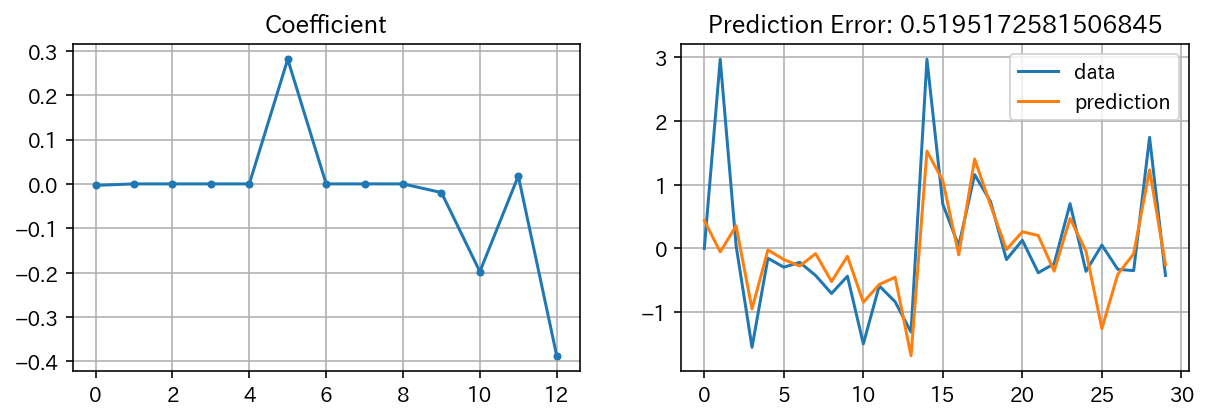

In [8]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(lasso.coef_, '.-')
plt.grid()
plt.title('Coefficient')
plt.subplot(1,2,2)
plt.plot(y_test[:num_test], label='data')
plt.plot(lasso.predict(X_test[:num_test]), label='prediction')
# plt.plot(y[:num_test], label='data')
# plt.plot(lasso.predict(X[:num_test]), label='prediction')
plt.legend()
plt.grid()
plt.title(f'Prediction Error: {lasso.score(X_test[:num_test], y_test[:num_test])}')
plt.show()

### HMLasso with no missed data

Given no missed data, then perform as Lasso.

In [9]:
hmlasso = HMLasso(alpha=alpha, mu_coef=1.0, mu_cov=0.1)

In [10]:
%%time
hmlasso.fit(X_train, y_train)
# hmlasso.fit(X, y)

CPU times: user 3.8 ms, sys: 2.22 ms, total: 6.02 ms
Wall time: 3.48 ms


HMLasso(alpha=0.1, copy_X=True, eps=1e-08, max_iter_coef=1000, max_iter_cov=100,
        mu_coef=1.0, mu_cov=0.1, normalize=False, tol_coef=0.0001,
        tol_cov=0.0001)

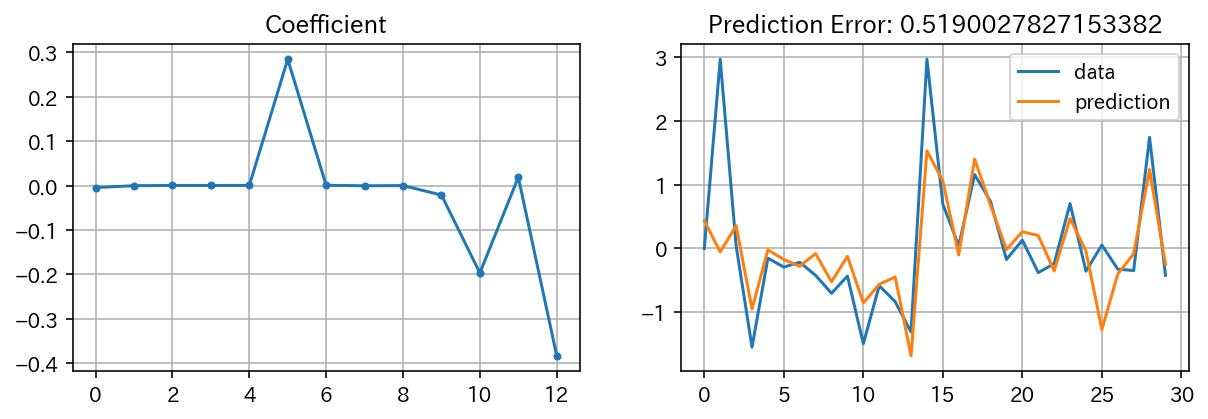

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(hmlasso.coef_, '.-')
plt.grid()
plt.title('Coefficient')
plt.subplot(1,2,2)
plt.plot(y_test[:num_test], label='data')
plt.plot(hmlasso.predict(X_test[:num_test]), label='prediction')
# plt.plot(y[:num_test], label='data')
# plt.plot(hmlasso.predict(X[:num_test]), label='prediction')
plt.legend()
plt.grid()
plt.title(f'Prediction Error: {hmlasso.score(X_test[:num_test], y_test[:num_test])}')
# plt.title(f'Prediction Error: {hmlasso.score(X[:num_test], y[:num_test])}')
plt.show()

### HMLasso with randomly missed data

In [12]:
X_randomly_missed = np.copy(X_train)
np.random.seed(0)
rand = np.random.rand(*X_train.shape)

# 25% missed
X_randomly_missed[rand > 0.75] = np.nan

In [13]:
%%time
hmlasso.fit(X_randomly_missed, y_train)

CPU times: user 4.01 ms, sys: 1.46 ms, total: 5.47 ms
Wall time: 3.19 ms


HMLasso(alpha=0.1, copy_X=True, eps=1e-08, max_iter_coef=1000, max_iter_cov=100,
        mu_coef=1.0, mu_cov=0.1, normalize=False, tol_coef=0.0001,
        tol_cov=0.0001)

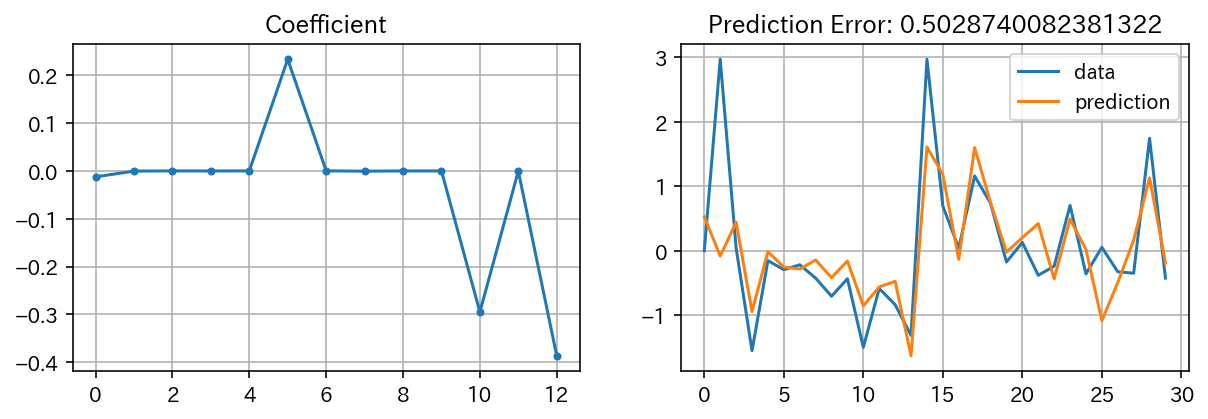

In [14]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(hmlasso.coef_, '.-')
plt.grid()
plt.title('Coefficient')
plt.subplot(1,2,2)
plt.plot(y_test[:num_test], label='data')
plt.plot(hmlasso.predict(X_test[:num_test]), label='prediction')
plt.legend()
plt.grid()
plt.title(f'Prediction Error: {hmlasso.score(X_test[:num_test], y_test[:num_test])}')
plt.show()

### HMLasso with center missed data

In [15]:
n_samples, n_features = X_train.shape
X_missed = np.copy(X_train)

# center 25% missed
X_missed[int(0.25*n_samples):int(0.75*n_samples), int(0.25*n_features):int(0.75*n_features)] = np.nan

In [16]:
%%time
hmlasso.fit(X_missed, y_train)

CPU times: user 5.61 ms, sys: 1.5 ms, total: 7.11 ms
Wall time: 4.62 ms


HMLasso(alpha=0.1, copy_X=True, eps=1e-08, max_iter_coef=1000, max_iter_cov=100,
        mu_coef=1.0, mu_cov=0.1, normalize=False, tol_coef=0.0001,
        tol_cov=0.0001)

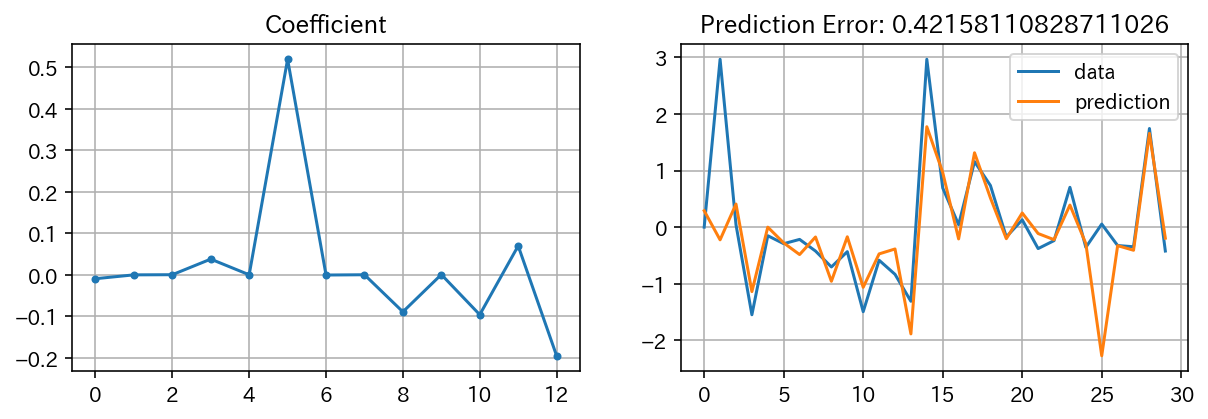

In [17]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(hmlasso.coef_, '.-')
plt.grid()
plt.title('Coefficient')
plt.subplot(1,2,2)
plt.plot(y_test[:num_test], label='data')
plt.plot(hmlasso.predict(X_test[:num_test]), label='prediction')
plt.legend()
plt.grid()
plt.title(f'Prediction Error: {hmlasso.score(X_test[:num_test], y_test[:num_test])}')
plt.show()